# Infill stylised pathway
Here we generate a portfolio of stylised CO2 pathways and infill them with other gases. Pathways are generated based on the functional form suggested in "What would it take to achieve the Paris temperature targets?" (Sanderson et al, 2016). They present two general formulae, one for total CO2 and one for other gases, including the AFOLU component of CO2. The industry and fossil fuel component of CO2 is found by requiring it and AFOLU to sum to the total CO2. 

In [1]:
import os.path

import pandas as pd
import pyam
import matplotlib.pyplot as plt
import matplotlib
import scipy.interpolate as interp
import numpy as np
from silicone.utils import (
    download_or_load_sr15,
)
import silicone.multiple_infillers as mi
import silicone.database_crunchers as cr

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


# Download data
We use the SR1.5 database to perform our infilling and use the CMIP5 database to provide the RCP8.5 and RCP2.6 pathways required by the stylised path equations. 

In [2]:
sr15_file = "./../Input/complete_sr15.csv"
download_or_load_sr15(sr15_file)

# We are only interested in the worldwide record
df = pyam.IamDataFrame(sr15_file).filter(region="World") 
df.head()

pyam.utils - INFO: Reading `./../Input/complete_sr15.csv`
pyam.utils - INFO: Reading `./../Input/complete_sr15.csv`


,model,scenario,region,variable,unit,year,meta,subannual,value
0,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2005,0,0.0,8.3367
1,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2010,0,0.0,7.6408
2,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2015,0,0.0,7.2724
3,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2020,0,0.0,7.0752
4,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2025,0,0.0,5.8486


In [3]:
rcmip_file = "./../Input/InterpolatedRCMIP_RCPs.csv"
rcmip_df = pyam.IamDataFrame(rcmip_file)

pyam.utils - INFO: Reading `./../Input/InterpolatedRCMIP_RCPs.csv`


## Use the formula to construct lines
Our basic input has separate functional forms for CO2 from land use and total CO2. We will base our pathway on the AIM/CGE 2.0 model. It requires three free parameters, $\tau$ (a decay constant), $t_m$ (a time to start the transition) and $E_\infty$, the long-run total CO2 emissions. There are two additional parameters defined by continuity conditions, $A$ and $t_e$. Note that we will slightly redefine $A$ from the paper to absorb $t_e$ (and correct what appears be a sign error before $E_\infty$) so that $E_{CO_2} = A(t-t_m)E^{-(t-t_m)/\tau}+E_\infty$. 

We will arbitrarily select $t_m = 2025, \tau = 10$ or 25 and $E_\infty = - 3400$ or 10000 (The negative case is around the 2150 limit of the RCP2.6 scenario)

In [4]:
rcmip_df.filter(variable="Emissions|CO2", year=2150, scenario="rcp26").data

,model,scenario,region,variable,unit,year,value
2583,IMAGE,rcp26,World,Emissions|CO2,Mt CO2/yr,2150,-3412.933333


In [5]:
taus = [10, 25]
t_m = 2025
E_infs = [10000, -3400]
t_max = 2100

### Constructing AFOLU statistics 
Now we have our inputs, we can calculate the AFOLU CO$_2$ that results from our cases. 

In [6]:
AFOLU = "Emissions|CO2|MAGICC AFOLU"
construct = rcmip_df.filter(scenario="rcp85", year=range(t_m))
ELU85 = rcmip_df.filter(
    variable=AFOLU, scenario="rcp85", year=range(t_m, t_max + 1)
)
ELU26 = rcmip_df.filter(
    variable=AFOLU, scenario="rcp26", year=range(t_m, t_max + 1)
)
ELU85.data.reset_index(inplace=True, drop=True)
ELU26.data.reset_index(inplace=True, drop=True)
ELU26.head()

,model,scenario,region,variable,unit,year,value
0,IMAGE,rcp26,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2025,3229.783333
1,IMAGE,rcp26,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2026,3162.353333
2,IMAGE,rcp26,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2027,3094.923333
3,IMAGE,rcp26,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2028,3027.493333
4,IMAGE,rcp26,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2029,2960.063333


In [7]:
constructed_df = None
def scenario_fn(tau, E_inf):
    return "tau_" + str(tau) + "_E-inf_" + str(E_inf)
def AFOLU_fn(t, t_m, tau, E85, E26):
    return E85 * np.exp(-(t - t_m) / tau)  + E26 * (1 - np.exp(-(t - t_m) / tau))
for tau in taus:
    for E_inf in E_infs:
        output = construct.copy()
        to_add = ELU85.copy()
        to_add["value"] = AFOLU_fn(ELU85["year"], t_m, tau, ELU85["value"], ELU26["value"])
        output.append(to_add, inplace=True)
        output["scenario"] = scenario_fn(tau, E_inf)
        if constructed_df:
            constructed_df.append(output, inplace=True)
        else:
            constructed_df = pyam.IamDataFrame(output.data)

In [8]:
constructed_df=pyam.IamDataFrame(constructed_df.data)
constructed_df.filter(variable="*CO2|MAGICC A*").data

,model,scenario,region,variable,unit,year,value
10,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2015,3575.366667
11,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2016,3525.060000
12,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2017,3474.753333
13,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2018,3424.446667
14,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2019,3374.140000
...,...,...,...,...,...,...,...
409,MESSAGE,tau_25_E-inf_10000,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2096,1917.560418
410,MESSAGE,tau_25_E-inf_10000,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2097,1887.185079
411,MESSAGE,tau_25_E-inf_10000,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2098,1856.711912
412,MESSAGE,tau_25_E-inf_10000,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2099,1826.143936


AFOLU CO$_2$ looks as follows in the different cases (compared :

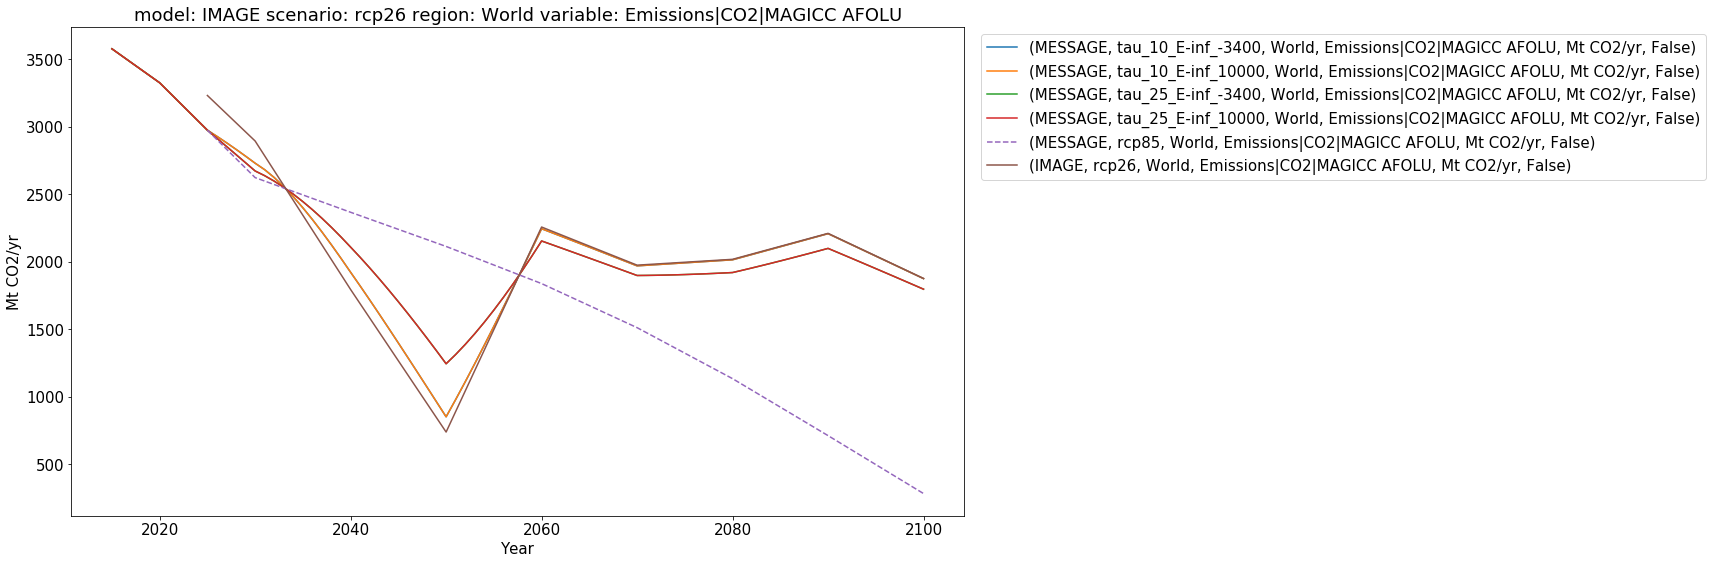

In [9]:
matplotlib.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
constructed_df.filter(variable=AFOLU).line_plot(ax=ax)
ELU85.line_plot(ax=ax, linestyle="--")
ELU26.line_plot(ax=ax)
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")

### Construct the total CO2 emissions
The total CO2 is also determined by similar if more complicated equations. Terms for $A$ and $t_e$ are calculated from continuity of value and derivative at $t_m$

In [10]:
def ETOT_fn(t, t_m, tau, t_e, A, E_inf):
    return A * (t-t_e) * np.exp(-(t-t_m)/tau) + E_inf
t_step = 1
ETOT_86 = rcmip_df.filter(
    variable="Emissions|CO2", scenario="rcp85", year=range(t_m - t_step, t_m + t_step + 1)
).data.set_index("year")
for tau in taus:
    for E_inf in E_infs:
        output = ELU85.copy()
        # A = (\tau dE/dt + E - E_inf)/(1 + \tau) evaluated at t_m
        A = (tau * (ETOT_86["value"].loc[t_m + t_step] - ETOT_86["value"].loc[t_m - t_step]) / (2 * t_step) \
            + (ETOT_86["value"].loc[t_m] - E_inf)) / (1 + tau)
        t_e = t_m - (ETOT_86["value"].loc[t_m] - E_inf) / A  
        output["value"] = ETOT_fn(np.arange(t_m, t_max + 1), t_m, tau, t_e, A, E_inf)
        output["scenario"] = scenario_fn(tau, E_inf)
        output["variable"] = "Emissions|CO2"
        constructed_df.append(output, inplace=True)

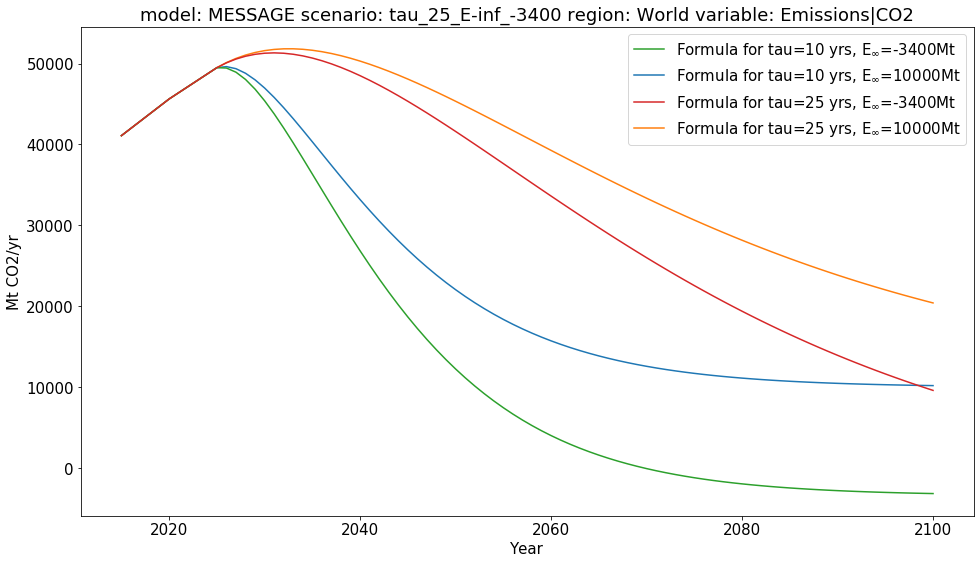

In [11]:
def label_formula(tau, Einf):
    return "Formula for tau=" + str(tau) + " yrs, E$_{\infty}$=" + str(Einf) + "Mt"
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
for Einf in E_infs:
    for tau in taus:
        constructed_df.filter(
            variable="Emissions|CO2", 
            scenario=scenario_fn(tau, Einf)
        ).line_plot(ax=ax, label=label_formula(tau, Einf))

In [12]:
industry_str = "Emissions|CO2|MAGICC Fossil and Industrial"
co2 = "Emissions|CO2"
ind_CO2 = mi.infill_composite_values(constructed_df, {industry_str: {
    co2: 1, AFOLU: -1
}})
ind_CO2.filter(variable="Emissions|CO2*", year=2020).head()

,model,scenario,region,variable,unit,year,value
5,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667
91,MESSAGE,tau_10_E-inf_10000,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667
177,MESSAGE,tau_25_E-inf_-3400,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667
263,MESSAGE,tau_25_E-inf_10000,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667


In [13]:
ind_CO2.filter(variable="Emissions|CO2|*", year=2020).head(10)

,model,scenario,region,variable,unit,year,value
5,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667
91,MESSAGE,tau_10_E-inf_10000,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667
177,MESSAGE,tau_25_E-inf_-3400,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667
263,MESSAGE,tau_25_E-inf_10000,World,Emissions|CO2|MAGICC Fossil and Industrial,Mt CO2/yr,2020,42304.166667


In [14]:
constructed_df.append(ind_CO2.filter(year=range(t_m), keep=False), inplace=True)

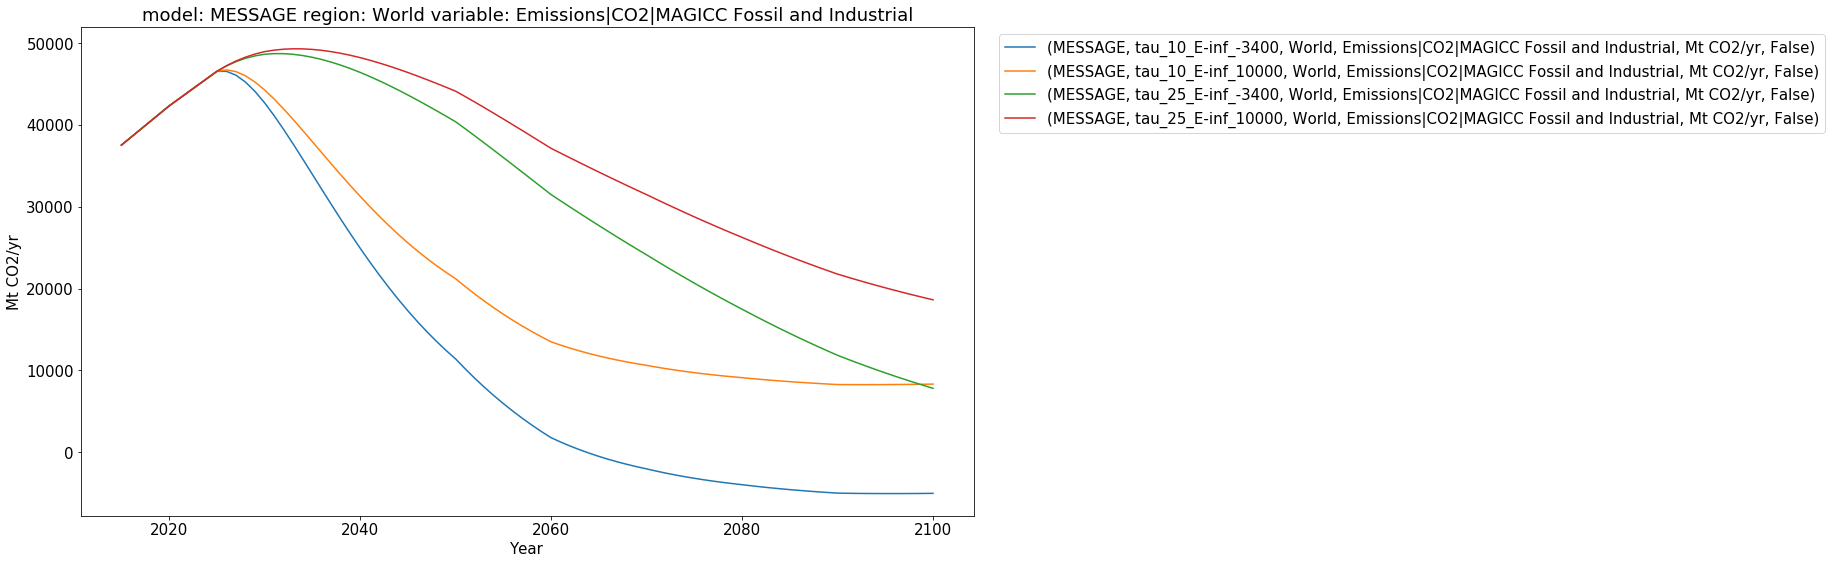

In [15]:
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
constructed_df.filter(variable=industry_str).line_plot(ax=ax)
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

## Compare with Silicone results
We can now compare the pathways implied by this method with the pathways infilled by our crunchers. We begin with the rolling quantile cruncher

In [16]:
cruncher_rcmip = cr.QuantileRollingWindows(rcmip_df)
infilled_rcmip = cruncher_rcmip.derive_relationship(AFOLU, [co2], nwindows=6)(constructed_df)
infilled_rcmip_01 = cruncher_rcmip.derive_relationship(AFOLU, [co2], quantile=0.1)(constructed_df)
infilled_rcmip_09 = cruncher_rcmip.derive_relationship(AFOLU, [co2], quantile=0.9)(constructed_df)

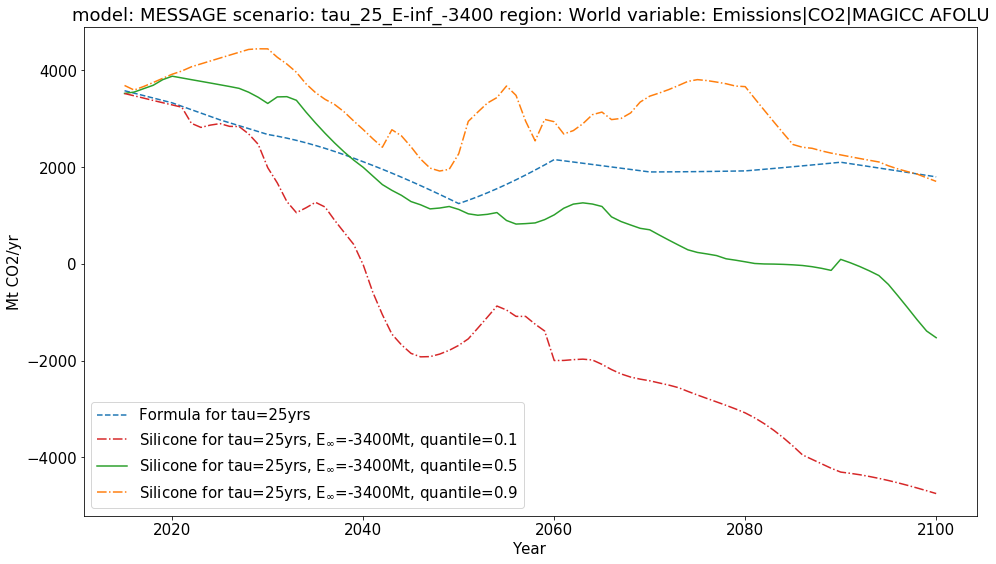

In [17]:
def label_formula(tau, Einf, quantile):
    return "Silicone for tau=" + str(tau) + "yrs, E$_{\infty}$=" + str(Einf) + "Mt, quantile=" +str(quantile)
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
# We only show one E-inf as they are identical
for tau in [taus[1]]:
    constructed_df.filter(variable=AFOLU, scenario="tau_" + str(tau) + "_E-inf_-*").line_plot(
        ax=ax, label="Formula for tau=" + str(tau) + "yrs", linestyle="--"
    ) 
    for Einf in [E_infs[1]]:
        infilled_rcmip_09.filter(variable=AFOLU, scenario=scenario_fn(tau, Einf)).line_plot(
            ax=ax, label=label_formula(tau, Einf, 0.9), linestyle="-."
        )
        infilled_rcmip.filter(variable=AFOLU, scenario=scenario_fn(tau, Einf)).line_plot(
            ax=ax, label=label_formula(tau, Einf, 0.5)
        )
        infilled_rcmip_01.filter(variable=AFOLU, scenario=scenario_fn(tau, Einf)).line_plot(
            ax=ax, label=label_formula(tau, Einf, 0.1), linestyle="-."
        )

Our main conclusion from this is that this database is too small to use this cruncher, hence the inter-year variability is too high. We now will repeat this, using the larger database from the IIASA SR 1.5 repository. This will require some relabelling to make variable names match. 

In [18]:
same_name_sr15 = df.filter(variable=["*CO2*", "*CH4*"])
same_name_sr15["variable"] = df.data["variable"].map(lambda x: x.replace(
    "Emissions|CO2|AFOLU", AFOLU
).replace("Emissions|CO2|Energy and Industrial Processes", industry_str))
for time in same_name_sr15["year"].unique():
    time = int(time)
    same_name_sr15.interpolate(time)

In [19]:
cruncher_sr15 = cr.QuantileRollingWindows(same_name_sr15)
infilled_sr15 = cruncher_sr15.derive_relationship(AFOLU, [co2], nwindows = 10)(
    constructed_df.filter(year=same_name_sr15["year"].unique())
)

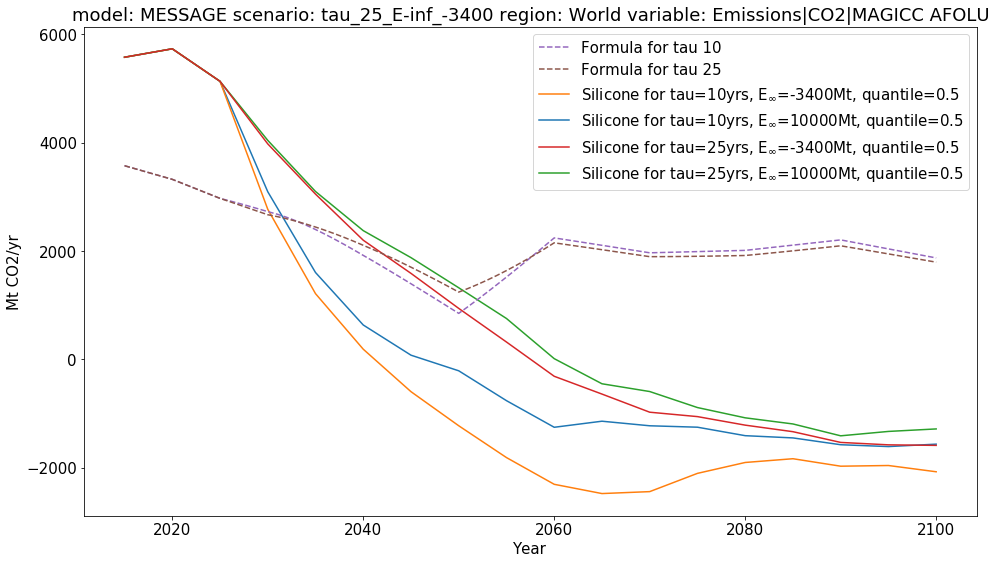

In [20]:
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
# We only show one E-inf as they are identical
for tau in taus:
    for Einf in E_infs:
        infilled_sr15.filter(variable=AFOLU, scenario=scenario_fn(tau, Einf)).line_plot(
            ax=ax, 
            label=label_formula(tau, Einf, 0.5)
        )
for tau in taus:
    constructed_df.filter(variable=AFOLU, scenario="tau_" + str(tau) + "_E-inf_-*").line_plot(
        ax=ax, label="Formula for tau " + str(tau), linestyle="--"
    ) 

In [21]:
infilled_sr15.filter(variable=AFOLU, year=2020).data

,model,scenario,region,variable,unit,year,value
1,MESSAGE,tau_10_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2020,5732.919329
19,MESSAGE,tau_10_E-inf_10000,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2020,5732.919329
37,MESSAGE,tau_25_E-inf_-3400,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2020,5732.919329
55,MESSAGE,tau_25_E-inf_10000,World,Emissions|CO2|MAGICC AFOLU,Mt CO2/yr,2020,5732.919329


In [22]:
infilled_sr15_09 = cruncher_sr15.derive_relationship(AFOLU, [co2], nwindows = 6, quantile=0.9)(
    constructed_df.filter(year=same_name_sr15["year"].unique())
)
infilled_sr15_01 = cruncher_sr15.derive_relationship(AFOLU, [co2], nwindows = 6, quantile=0.1)(
    constructed_df.filter(year=same_name_sr15["year"].unique())
)

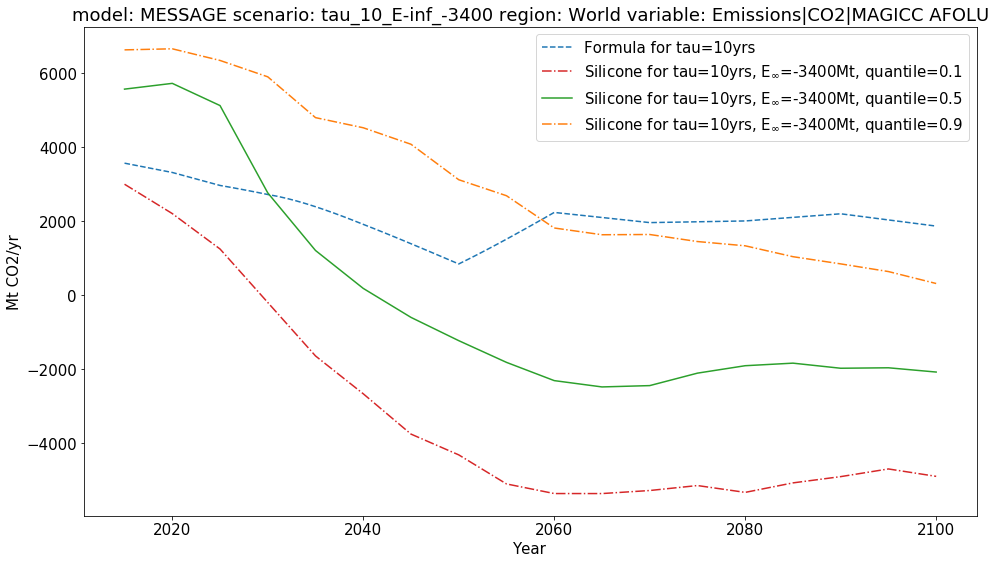

In [23]:
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
for tau in [taus[0]]:
    # We only show one E-inf as they are identical
    constructed_df.filter(variable=AFOLU, scenario="tau_" + str(tau) + "_E-inf_-*").line_plot(
        ax=ax, label="Formula for tau=" + str(tau) + "yrs", linestyle="--"
    ) 
    for Einf in [E_infs[1]]:
        infilled_sr15_09.filter(variable=AFOLU, scenario=scenario_fn(tau, Einf)).line_plot(
            ax=ax, label=label_formula(tau, Einf, 0.9), linestyle="-."
        )
        infilled_sr15.filter(variable=AFOLU, scenario=scenario_fn(tau, Einf)).line_plot(
            ax=ax, 
            label=label_formula(tau, Einf, 0.5)
        )
        infilled_sr15_01.filter(variable=AFOLU, scenario=scenario_fn(tau, Einf)).line_plot(
            ax=ax, label=label_formula(tau, Einf, 0.1), linestyle="-."
        )

We see the results are much smoother and more believable. 

## Infilling with a linear interpolator
We can instead infill this in a way consistent with the SSP scenarios 1-3 implemented by the MESSAGE model. We do this by interpolating between the two closest lead values from that database. We will use total CO2 as the lead variable as above. We will perform the analysis for both AFOLU and methane. 

In [24]:
constructed_df_years = constructed_df.filter(year=same_name_sr15["year"].unique())
cruncher = cr.ScenarioAndModelSpecificInterpolate(same_name_sr15)
scenarios = ["SSP1*", "SSP2*", "SSP3*"]
ch4 = "Emissions|CH4"
infilled_AFOLU = {}
infilled_CH4 = {}
for scenario in scenarios:
    infilled_AFOLU[scenario] = cruncher.derive_relationship(
        AFOLU,
        [co2],
        required_model="MESSAGE*", 
        required_scenario=scenario
    )(constructed_df_years)
    infilled_CH4[scenario] = cruncher.derive_relationship(
        ch4,
        [co2],
        required_model="MESSAGE*", 
        required_scenario=scenario
    )(constructed_df_years)

In [25]:
def interp_label_formula(tau, Einf):
    return "Silicone for tau=" + str(tau) + "yrs, E$_{\infty}$=" + str(Einf) + "Mt"

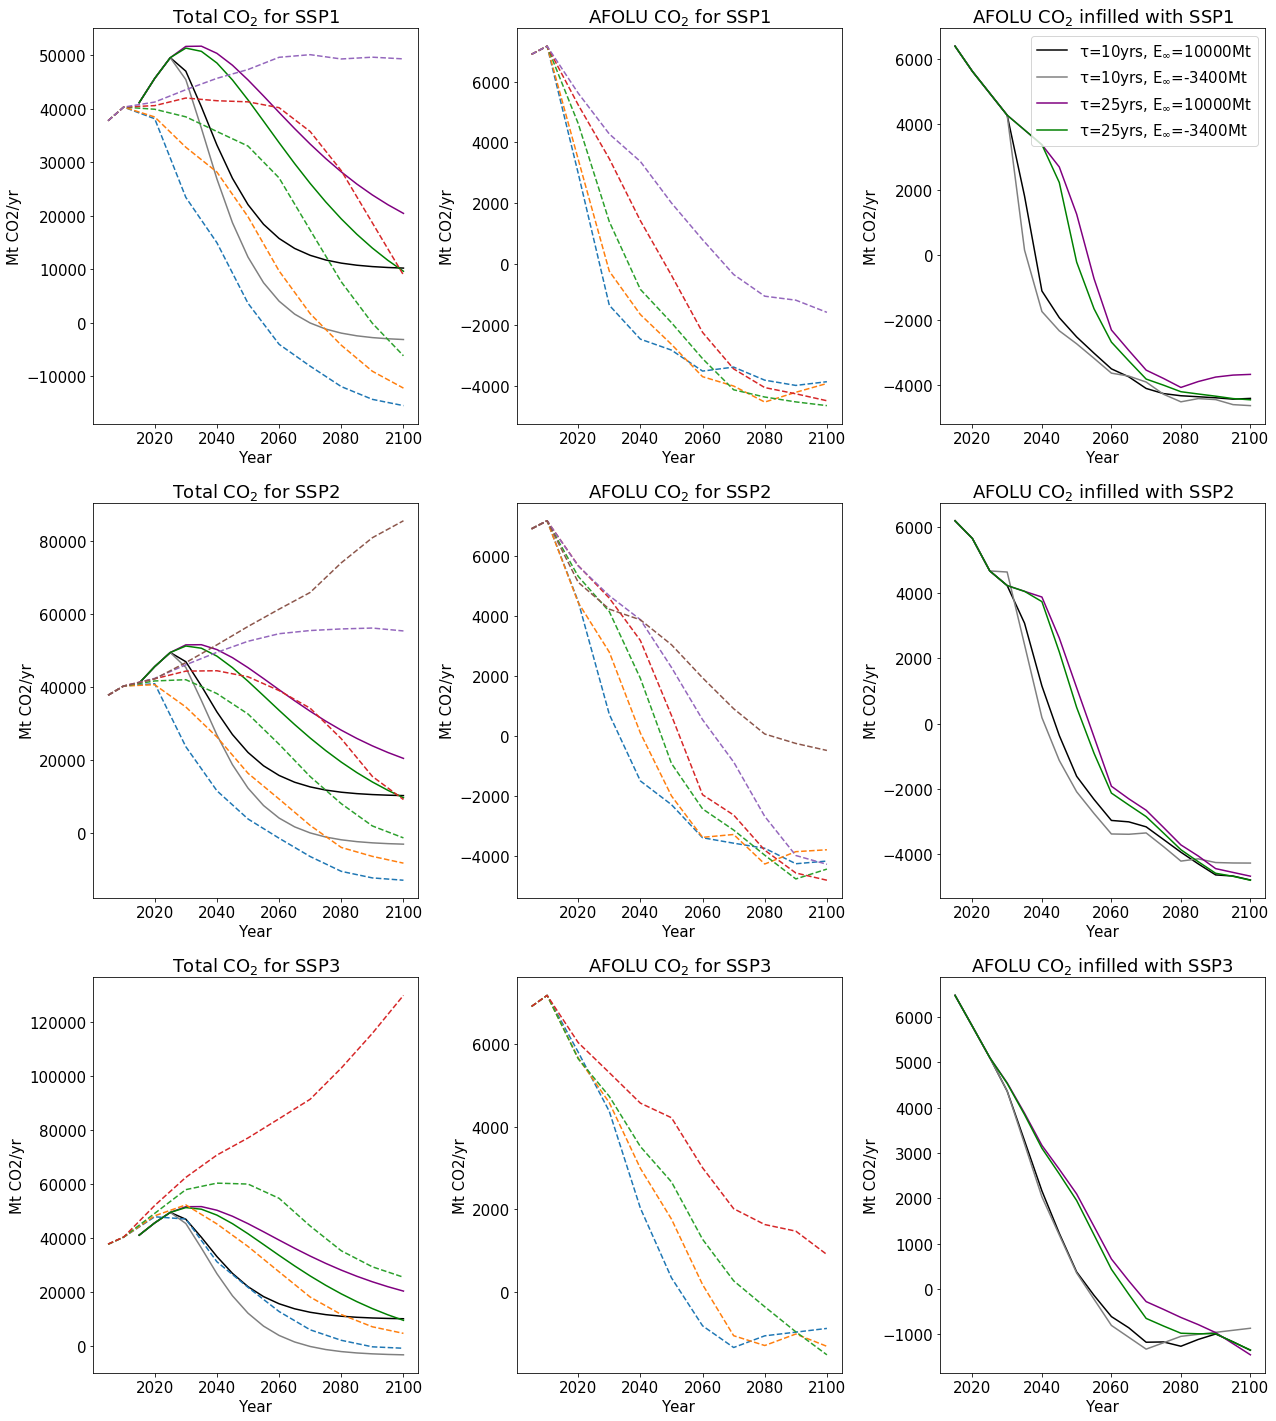

In [26]:
fig = plt.figure(figsize=(18, 20))
color_dict = {
    (E_infs[0], taus[0]): "black", 
    (E_infs[1], taus[0]): "grey", 
    (E_infs[0], taus[1]): "purple", 
    (E_infs[1], taus[1]): "green"
}
for i, scenario in enumerate(scenarios):
    ax = fig.add_subplot(3, 3, 3 * i + 1)
    for tau in taus:
        for Einf in E_infs:
            constructed_df_years.filter(variable=co2, scenario=scenario_fn(tau, Einf)).line_plot(
                ax=ax, color=color_dict[(Einf, tau)]
            )
    same_name_sr15.filter(variable=co2, scenario=scenario, model="MESSAGE*").line_plot(
        ax=ax, linestyle="--", label="__"
    )
    ax.get_legend().remove()
    ax.set_title("Total CO$_2$ for {}".format(scenario[0:4]))
    ax = fig.add_subplot(3, 3, 3 * i + 2)
    same_name_sr15.filter(variable=AFOLU, scenario=scenario, model="MESSAGE*").line_plot(
        ax=ax, linestyle="--", label="__"
    )
    ax.set_title("AFOLU CO$_2$ for {}".format(scenario[0:4]))
    ax.get_legend().remove()
    ax = fig.add_subplot(3, 3, 3 * i + 3)
    for tau in taus:
        for Einf in E_infs:
            infilled_AFOLU[scenario].filter(scenario=scenario_fn(tau, Einf)).line_plot(
                ax=ax, label=chr(964) + "=" + str(tau) + "yrs, E$_{\infty}$=" + str(Einf) + "Mt", color=color_dict[(Einf, tau)]
            )
    ax.set_title("AFOLU CO$_2$ infilled with {}".format(scenario[0:4]))
    if i != 0:
        ax.get_legend().remove()
    else:
        ax.legend(loc='upper right')
fig.tight_layout()

Investigating the lineshape of the input, we see good agreement with the SSP3 shape and so if no narrative force indicates the preference of any SSP model, we would conclude that the bottom right image is probably best. We can also plot the same relationship for methane. 

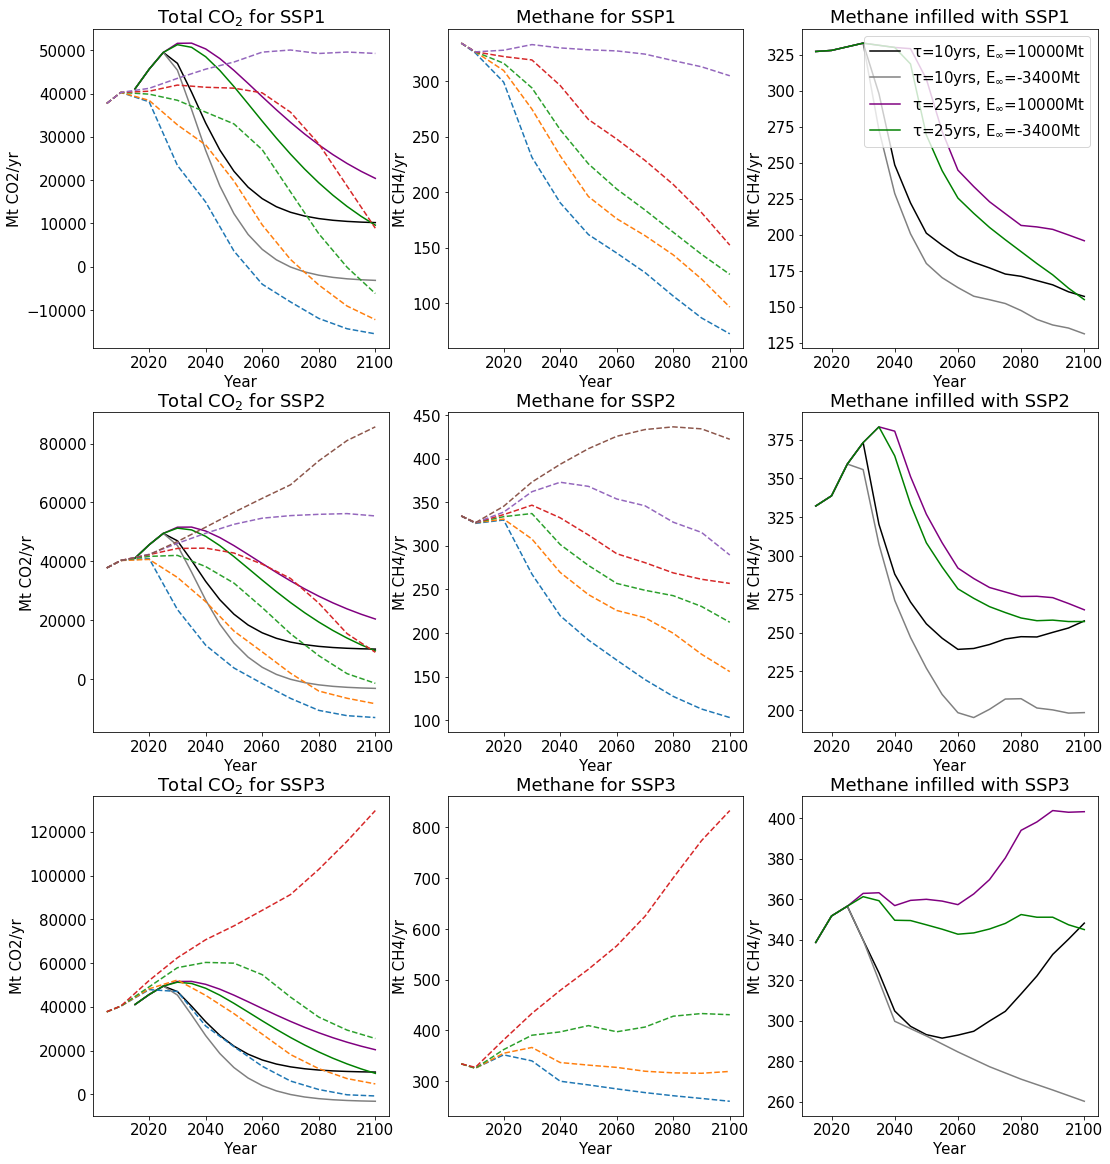

In [27]:
fig = plt.figure(figsize=(18, 20))
fig.tight_layout()
for i, scenario in enumerate(scenarios):
    ax = fig.add_subplot(3, 3, 3 * i + 1)
    for tau in taus:
        for Einf in E_infs:
            constructed_df_years.filter(variable=co2, scenario=scenario_fn(tau, Einf)).line_plot(
                ax=ax, color=color_dict[(Einf, tau)]
            )
    same_name_sr15.filter(variable=co2, scenario=scenario, model="MESSAGE*").line_plot(
        ax=ax, linestyle="--", label="__", 
    )
    ax.get_legend().remove()
    ax.set_title("Total CO$_2$ for {}".format(scenario[0:4]))
    ax = fig.add_subplot(3, 3, 3 * i + 2)
    same_name_sr15.filter(variable=ch4, scenario=scenario, model="MESSAGE*").line_plot(
        ax=ax, linestyle="--", label="__"
    )
    ax.set_title("Methane for {}".format(scenario[0:4]))
    ax.get_legend().remove()
    ax = fig.add_subplot(3, 3, 3 * i + 3)
    for tau in taus:
        for Einf in E_infs:
            infilled_CH4[scenario].filter(scenario=scenario_fn(tau, Einf)).line_plot(
                ax=ax, label=chr(964) + "=" + str(tau) + "yrs, E$_{\infty}$=" + str(Einf) + "Mt", color=color_dict[(Einf, tau)]
            )
    ax.set_title("Methane infilled with {}".format(scenario[0:4]))
    if i != 0:
        ax.get_legend().remove()
    else:
        ax.legend(loc='upper right')    

Again, the similarity of lead value paths indicates that the bottom right image is probably preferable. 